In [48]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle
from photutils.aperture import SkyCircularAperture 
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.visualization import simple_norm
from pathlib import Path
import re
import pandas as pd
from photutils.aperture import ApertureStats
from photutils.datasets import make_wcs
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic,centroid_sources)
import sys
parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))
from constants import wavelength_bins
import instruments as inst
# test file
fn = '/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/cubes/n0001e_flat.fits'

In [6]:
# Convert to degrees
from astropy.coordinates import SkyCoord
from astropy import units as u

# From your header
ra_str = '19:36:46.604'
dec_str = '+35:14:43.28'

# Parse into a SkyCoord (ICRS is standard for RA/DEC in FITS)
coord = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg), frame='icrs')

print(coord)
print("RA (deg):", coord.ra.deg)
print("Dec (deg):", coord.dec.deg)

pix_1x  = 131
pix_1y = 116
pix_2x=67
pix_2y=83
wcs1 = make_wcs((pix_1x,pix_1y))
wcs2= make_wcs((pix_2x,pix_2y))
aperture = CircularAperture((pix_1x,pix_1y),r=4)
sky_aperture1 = aperture.to_sky(wcs1)
sky_aperture2 = aperture.to_sky(wcs2)
sky_aperture1

<SkyCoord (ICRS): (ra, dec) in deg
    (294.19418333, 35.24535556)>
RA (deg): 294.19418333333334
Dec (deg): 35.245355555555555


<SkyCircularAperture(<SkyCoord (ICRS): (ra, dec) in deg
    (197.89271118, -1.36306012)>, r=0.39999999916790907 arcsec)>

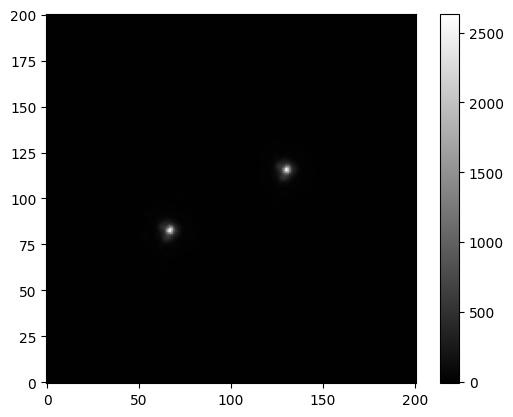

In [7]:
# Split the images into the wollaston beams
test_hdul = fits.open(fn)
image_data = (test_hdul[1].data)#[:,:,:99]
image_data_right = (test_hdul[1].data)[:,:,100:200]
#aperture.plot(color='red')
plt.imshow(image_data[12], origin='lower', cmap='gray')
plt.colorbar()
plt.show()

image_data=image_data

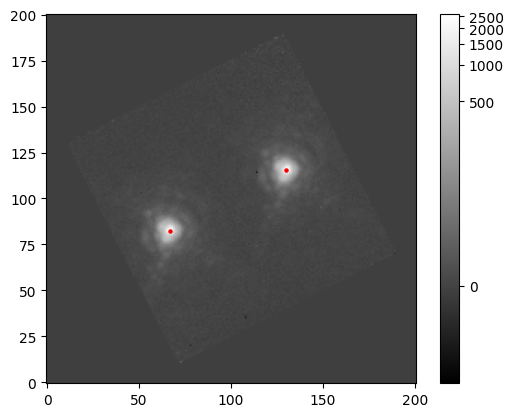

In [72]:
# Centroid the PSFs, test bin 12
test_data = image_data[12]
bgsub = test_data - np.median(test_data[120:134,37:63])
# x_r, y_r= centroid_com(r_bgsub[12])
# x_l,y_l= centroid_com(l_bgsub[12])
x_init = (66,132)
y_init = (81,115)
x,y = centroid_sources(bgsub,x_init,y_init,box_size=45,centroid_func=centroid_2dg)
snorm = simple_norm(bgsub,'log',)

plt.imshow(bgsub, origin='lower', cmap='grey',norm=snorm)
plt.colorbar()
plt.scatter(x,y,color='red', s=5)

# streamline into func
def charis_centroids_one_psf(image_data,initial_guess_l,initial_guess_r,box_size,wavelength_bin):
    """
    Fits centroids for CHARIS specpol mode using center of mass fit, assuming only one PSF per Wollaston beam.
    Fits all wavelength bins using an initial guess. Uses photutils centroid_sources()
    with centroid function centroid_com().

    Parameters
    -----------
    image_data: np.3darray
        CHARIS FITS cube image data. Axes should be (wavelength,y,x)
        Should be background subtracted.

    initial_guess_l: list or np.1darray
        Initial guess for the PSF centroid for the left beam [x,y].

    initial_guess_l: list or np.1darray
        Initial guess for the PSF centroid for the right beam [x,y].

    box_size: int
        Length of the square box where the algorithm will search for
        the PSF center. 
    
    wavelength_bin: int
        Which wavelength bin to centroid. 

    
    Returns:
    --------

    centroid_list: np.2darray
        Array of left and right beam centroids. 

    """

    

    # Iterate through all bins
    
    image_data_bin_n = image_data

    # Grab initial guesses and calculate centroids
    x_init = (initial_guess_l[0],initial_guess_r[0])
    y_init = (initial_guess_l[1], initial_guess_r[1])
    x,y = centroid_sources(image_data_bin_n,x_init,y_init,box_size,centroid_func=centroid_com)
    centroid_list = [[x[0],y[0]],[x[1],y[1]]]
   
    return centroid_list








In [25]:
import numpy as np
from scipy.optimize import curve_fit

SQRT_8_LN2 = np.sqrt(8.0 * np.log(2.0))

def _gauss2d(coords, amp, x0, y0, sx, sy, theta):
    """Elliptical 2D Gaussian, no background term."""
    x, y = coords
    ct, st = np.cos(theta), np.sin(theta)
    xr =  (x - x0) * ct + (y - y0) * st
    yr = -(x - x0) * st + (y - y0) * ct
    return amp * np.exp(-0.5 * ((xr / sx)**2 + (yr / sy)**2))

def fit_two_psfs_fwhm(image, centers, box=31):
    """
    Fit elliptical Gaussians to TWO PSFs and return major/minor FWHM.

    Parameters
    ----------
    image   : 2D np.ndarray (background already subtracted)
    centers : [(y1,x1), (y2,x2)] approximate PSF centers in pixels
    box     : int or (box_y, box_x), crop size around each center

    Returns
    -------
    fwhms : list of (fwhm_major, fwhm_minor) for each PSF
    """
    img = np.asarray(image)
    ny, nx = img.shape
    by, bx = (box, box) if isinstance(box, int) else box

    fwhms = []
    for (cy, cx) in centers:
        # crop
        y0 = max(0, int(round(cy)) - by//2); y1 = min(ny, y0 + by)
        x0 = max(0, int(round(cx)) - bx//2); x1 = min(nx, x0 + bx)
        sub = img[y0:y1, x0:x1]

        Y, X = np.mgrid[0:sub.shape[0], 0:sub.shape[1]]

        # initial guesses
        amp0 = float(sub.max())
        x0_0 = cx - x0
        y0_0 = cy - y0
        sx0 = sy0 = max(box/6, 1.0)
        theta0 = 0.0
        p0 = [amp0, x0_0, y0_0, sx0, sy0, theta0]

        # fit
        coords = np.vstack((X.ravel(), Y.ravel()))
        data = sub.ravel()
        popt, _ = curve_fit(
            _gauss2d, coords, data, p0=p0,
            bounds=([0,0,0,0.3,0.3,-np.pi/2],[np.inf,sub.shape[1],sub.shape[0],20,20,np.pi/2])
        )
        _, _, _, sx, sy, theta = popt

        # pick major/minor
        widths = np.array([sx, sy])
        s_major, s_minor = widths[np.argsort(widths)[::-1]]
        fwhms.append((SQRT_8_LN2*s_major, SQRT_8_LN2*s_minor))

    return fwhms

In [83]:
# Perform aperture photometry using a test bin

centroids = charis_centroids_one_psf(image_data,[65,83],[133,118],45,10)
test_centroid_l = centroids[0]
test_centroid_r = centroids[1]


# Define aperture at centroid with radius of FWHM
aperture_test_l = CircularAperture(test_centroid_l,r=5.2)
aperture_test_r = CircularAperture(test_centroid_r,r=5.2)

# Define annulus for background subtraction
annulus_test_l = CircularAnnulus(test_centroid_l,15,25)
annulus_test_r = CircularAnnulus(test_centroid_r,15,25)
plt.imshow(image_data[10])
annulus_test_l.plot(color='white',alpha=0.5)
annulus_test_r.plot(color='white',alpha=0.5)

aperture_test_l.plot(color='white')
aperture_test_r.plot(color='white')

# Calculate mean
aperstats_test_l = ApertureStats(image_data[10],annulus_test_l)
aperstats_test_r = ApertureStats(image_data[10],annulus_test_r)

mean_test_l = aperstats_test_l.mean
mean_test_r = aperstats_test_r.mean

# Perform aperture photometry
sum_test_l = aperture_photometry(image_data[10],aperture_test_l)['aperture_sum'][0] - mean_test_l*aperture_test_l.area
sum_test_r = aperture_photometry(image_data[10],aperture_test_r)['aperture_sum'][0] - mean_test_r*aperture_test_r.area

# Calculate single sums and differences
test_diff = sum_test_r-sum_test_l
test_sum = sum_test_l+sum_test_r

print(mean_test_l*aperture_test_l.area)



ValueError: xpos, ypos values contains point(s) outside of input data

In [93]:
def single_sum_and_diff_psf(fits_cube_path, wavelength_bin, aperture_l,aperture_r,annulus_l=None,annulus_r=None):
    """Calculate single difference and sum between left and right beam 
    rectangular aperture photometry from a single psf. Add L/R counts and stds to array.
    
    Parameters:
    -----------
    fits_cube_path : str or Path
        Path to the CHARIS fits cube file.
        
    wavelength_bin : int
        Index of the wavelength bin to analyze (0-based).

    aperture_l: photutils.aperture.Aperture
        Photutils aperture object for the left Wollaston beam.

    aperture_r: photutils.aperture.Aperture
        Photutils aperture object for the right Wollaston beam.

    annulus_l: photutils.aperture.Annulus, optional
        Photutils annulus object for local background subtraction for left Wollaston beam.
        Provide r and l or it will be skipped.

    annulus_r: photutils.aperture.Annulus, optional
        Photutils annulus object for local background subtraction for right Wollaston beam.
        Provide r and l or it will be skipped.

    Returns:
    --------
    np.ndarray
        Array with six elements:
            [0] single_sum : float
                Single sum of left and right beam apertures:
                (R + L)
            [1] single_diff : float
                Single difference of left and right beam apertures:
                (R - L) / (R + L)
            [2] left_counts : float
                Left beam aperture counts.
            [3] right_counts : float
                Right beam aperture counts.
            [4] sum_std : float
                Standard deviation of the single sum.
            [5] diff_std : float
                Standard deviation of the single difference.
    """
    
    # check if fits_cube_path is a valid file path
    fits_cube_path = Path(fits_cube_path)
    if not fits_cube_path.is_file():
        raise FileNotFoundError(f"File not found: {fits_cube_path}")
    
    # retrieve fits cube data
    hdul = fits.open(fits_cube_path)
    cube_data = hdul[1].data

    # check if data is a 3d cube (wavelength, y, x)

    if cube_data.ndim != 3:
        raise ValueError("Input data must be a 3D cube (wavelength, y, x).")
        
    # check if wavelength_bin is within bounds
    if not (0 <= wavelength_bin < cube_data.shape[0]):
        raise ValueError(f"wavelength_bin must be between 0 and {cube_data.shape[0] - 1}.")
    
    image_data = cube_data[wavelength_bin]

    # define apertures perform aperture photometry 
    phot_lbeam = aperture_photometry(image_data, aperture_l)
    phot_rbeam = aperture_photometry(image_data, aperture_r)

    # optional bkgd subtraction
    if annulus_l is not None and annulus_r is not None:
        
        bkgd_l = ApertureStats(image_data,annulus_l).mean
        bkgd_r = ApertureStats(image_data, annulus_r).mean

    # get left and right counts
    left_counts = phot_lbeam['aperture_sum'][0]
    right_counts = phot_rbeam['aperture_sum'][0]

    # optional bkgd subtraction
    if (annulus_l is not None) and (annulus_r is not None) :
        bkgd_l = ApertureStats(image_data,annulus_l).mean
        bkgd_r = ApertureStats(image_data, annulus_r).mean
        left_counts -= bkgd_l*aperture_l.area
        right_counts -= bkgd_r*aperture_r.area

    # calculate normalized single difference and sum
    single_sum = right_counts + left_counts
    single_diff = right_counts - left_counts 

    # Get error on each of the apertures
    std_l = ApertureStats(image_data,aperture_l).std
    std_r = ApertureStats(image_data,aperture_r).std
    sum_std = diff_std = np.sqrt(std_l**2+std_r**2)
    
    return (single_sum, single_diff, left_counts, right_counts, sum_std, diff_std)

In [94]:
centroid_guesses = ([65,83],[133,118])

anul_l = CircularAnnulus(centroid_guesses[0],15,25)

anul_r = CircularAnnulus(centroid_guesses[1],15,25)
single_sum_and_diff_psf('/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/cubes_forcsv/CRSA00123422_flat.fits',10,aperture_test_l,aperture_test_r,anul_l,anul_r)

(137581.53671050488,
 -2712.4615566157445,
 70146.99913356031,
 67434.53757694457,
 905.1439699303218,
 905.1439699303218)

In [110]:
import traceback
def write_fits_info_to_csv_psf(cube_directory_path, raw_cube_path, output_csv_path,centroid_guesses,aperture_radii, box_size,wavelength_bin,hwp_order=[0,45,11.25,56.25,22.5,67.5,33.75,78.75],hwp_angles_to_delete=[90],bkgd_annuli_radii=None,plot=False):
    """
    
    Write filepath, D_IMRANG (derotator angle), RET-ANG1 (HWP angle), 
    single sum, single difference, LCOUNTS, RCOUNTS, difference std,
    sum std, and wavelength values for a wavelength bin from each fits cube in the directory.
    Default HWP order and deletion works for future double difference calculation. 

    FITS parameters are extracted from raw files, while single sum and difference are calculated using the
    fits cube data and the defined rectangular apertures.
    If the necessary header keywords are not present, the values will be set to NaN.

    Note - This function assumes that the raw and extracted cubes have the same number in the filepath. If
    you processed your cubes in the CHARIS DPP, this is not the case. 
    
    Parameters:
    -----------

    cube_directory_path : str or Path
        Path to the directory containing CHARIS fits cubes.
        
    raw_cube_path : str or Path
        Path to the directory containing the matching raw CHARIS FITS files.

    output_csv_path : str or Path
        Path where the output csv will be created.

    centroid_guesses : tuple
        [0] left centroid guess: list or np.1darray
            Initial guess for the centroid location of the left Wollaston beam PSF [x,y].
        [1] right centroid guess: list or np.1darray
            Initial guess for the centroid location of the right Wollaston beam PSF [x,y].

    aperture_radii : list or np.1darry
        Radii to use for the circular apertures. [L,R]

    box_size: int
        Length of the square box where the algorithm will search for
        the PSF center. 

    wavelength_bin : int
        Index of the wavelength bin to analyze (0-based).

    hwp_order: list or np.ndarray, optional
        List of desired HWP order. Default works for double difference calculations.

    todelete: list or np.ndarray, optional
        List of HWP angles to delete. Default works
        for double difference calculations. Set to None if you want to keep them all. 

    bkgd_annuli_radii: tuple, optional
        [0] left radii: list or np.1darray
        Inside and outside radii length in pixels for the local background subtraction
        annulus of the left Wollaston aperture [inside,outside].
        [1] right radii: list or np.1darray
        Inside and outside radii length in pixels for the local background subtraction
        annulus of the right Wollaston aperture [inside,outside].

    plot: bool, optional
        Plots apertures against image data.

    Returns:
    --------

    None
        Write all info to a csv with these columns: "filepath", "D-IMRANG", "RET-ANG1", "single_sum", "single_diff",
        "LCOUNTS","RCOUNTS", "sum_std", "diff_std", "wavelength_bin"

    """

    
    # check for valid file paths
    cube_directory_path = Path(cube_directory_path)
    raw_cube_path = Path(raw_cube_path)
    output_csv_path = Path(output_csv_path)

    if not cube_directory_path.is_dir():
        raise NotADirectoryError(f"Directory not found: {cube_directory_path}")
    if output_csv_path.suffix != '.csv':
        raise ValueError(f"Output path must be a CSV file, got {output_csv_path}")
    if not raw_cube_path.is_dir():
        raise NotADirectoryError(f"Raw cube directory does not exist: {raw_cube_path}")
    if wavelength_bin > 21:
        raise ValueError(f"This function is currently only compatible with lowres mode, with 22 wavelength bins.")
    
    # prepare output csv file
    output_csv_path = Path(output_csv_path)
    with open(output_csv_path, 'w') as f:
        f.write("filepath,D_IMRANG,RET-ANG1,single_sum,single_diff,LCOUNTS,RCOUNTS,sum_std,diff_std,wavelength_bin\n")

        # iterate over all fits files in the directory
        for fits_file in sorted(cube_directory_path.glob('*.fits')):
            try:

                # check if corresponding raw fits file exists
                match = re.search(r"(\d{8})", fits_file.name)
                if not match:
                    raise ValueError(f"Could not extract 8-digit ID from filename {fits_file.name}")
                fits_id = match.group(1)
                raw_candidates = list(raw_cube_path.glob(f"*{fits_id}*.fits"))
                if not raw_candidates:
                    raise FileNotFoundError(f"No raw FITS file found for ID {fits_id}")
                raw_fits = raw_candidates[0]
                
                with fits.open(raw_fits) as hdul_raw:
                    raw_header = hdul_raw[0].header
                    d_imrang = raw_header.get("D_IMRANG", np.nan)
                    ret_ang1 = raw_header.get("RET-ANG1", np.nan)

                # round d_imrang to nearest 0.5
                #d_imrang = (np.round(d_imrang * 2) / 2)

                # extract image data
                hdul = fits.open(fits_file)
                cube_data = hdul[1].data
                image_data = cube_data[wavelength_bin]
                
                # find centroids of psfs
                centroids = charis_centroids_one_psf(image_data,centroid_guesses[0],centroid_guesses[1],box_size,wavelength_bin)
                
                # create circular apertures
                aper_l = CircularAperture(centroids[0],r=aperture_radii[0])
                aper_r = CircularAperture(centroids[1], r=aperture_radii[1])

                # calculate single sum and normalized single difference
                if bkgd_annuli_radii:
                    bkgd_annulus_l = CircularAnnulus(centroids[0],bkgd_annuli_radii[0][0],bkgd_annuli_radii[0][1])
                    bkgd_annulus_r = CircularAnnulus(centroids[1],bkgd_annuli_radii[1][0],bkgd_annuli_radii[1][1])
                    single_sum, single_diff, LCOUNTS, RCOUNTS, sum_std, diff_std = single_sum_and_diff_psf(fits_file,wavelength_bin,aper_l,aper_r,bkgd_annulus_l,bkgd_annulus_r)
                else:
                    single_sum, single_diff, LCOUNTS, RCOUNTS, sum_std, diff_std = single_sum_and_diff_psf(fits_file,wavelength_bin,aper_l,aper_r)

                # wavelength bins for lowres mode
                bins = wavelength_bins
                
                # write to csv file
                f.write(f"{fits_file}, {d_imrang}, {ret_ang1}, {single_sum}, {single_diff}, {LCOUNTS}, {RCOUNTS}, {sum_std}, {diff_std}, {bins[wavelength_bin]}\n")

                if plot:
                    fig, ax = plt.subplots(figsize=(10,6))
                    snorm = simple_norm(image_data,'log',)
                    im = ax.imshow(image_data, origin='lower', cmap='inferno',norm=snorm)
                    aper_l.plot(ax,color='white')
                    aper_r.plot(ax,color='white')
                    if bkgd_annuli_radii:
                        CircularAnnulus(centroids[0],bkgd_annuli_radii[0][0],bkgd_annuli_radii[0][1]).plot(ax,color='white',alpha=0.5)
                        CircularAnnulus(centroids[1],bkgd_annuli_radii[1][0],bkgd_annuli_radii[1][1]).plot(ax,color='white',alpha=0.5)
                    fig.colorbar(im,ax=ax)
                    

            except Exception as e:
                print(f"Error processing {fits_file}: {e}")
                traceback.print_exc()

    # sort HWP angles
    if hwp_order:
        inst.arr_csv_HWP(output_csv_path,hwp_order,todelete=hwp_angles_to_delete)

    print(f"CSV file written to {output_csv_path}")

CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/csvs/bin10.csv


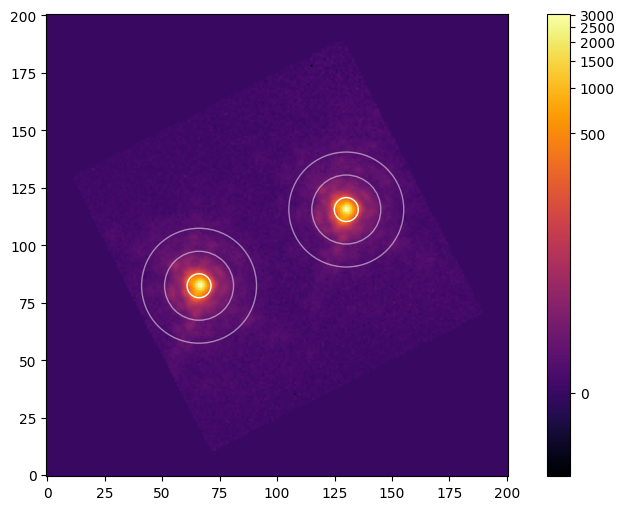

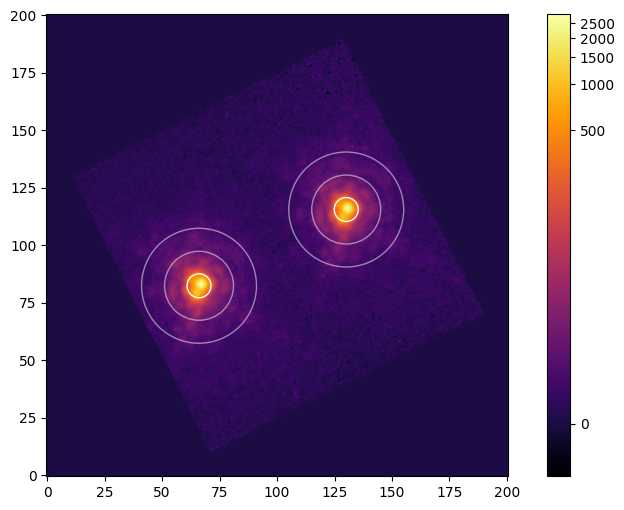

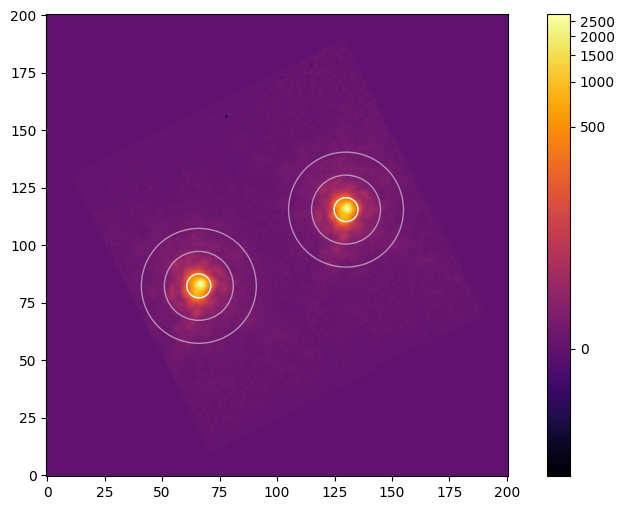

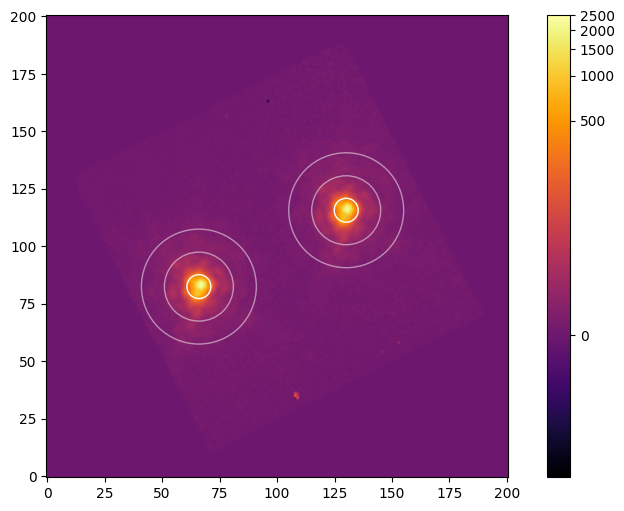

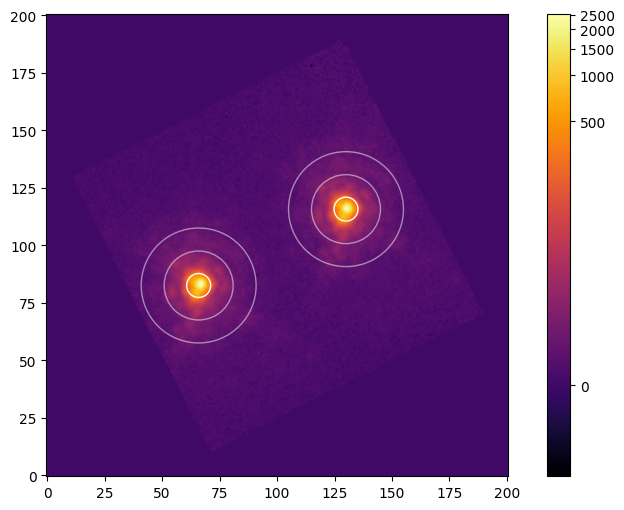

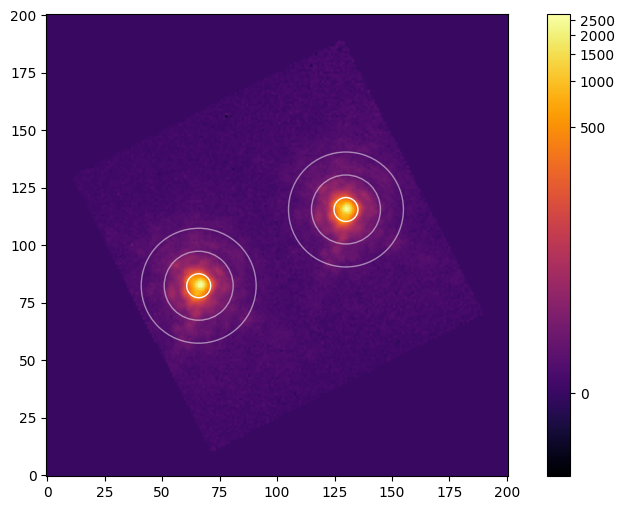

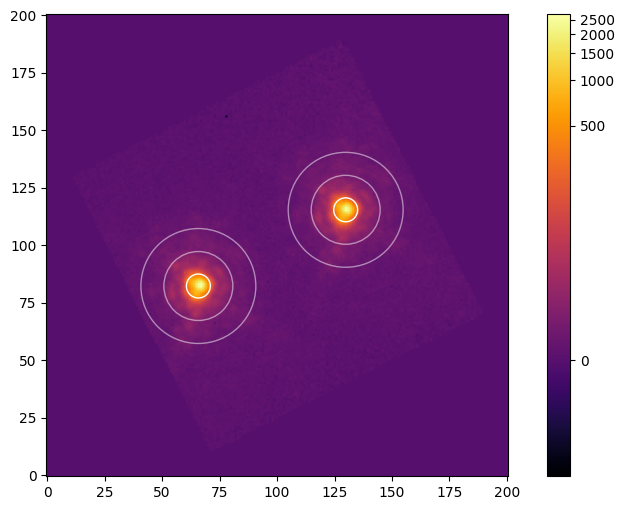

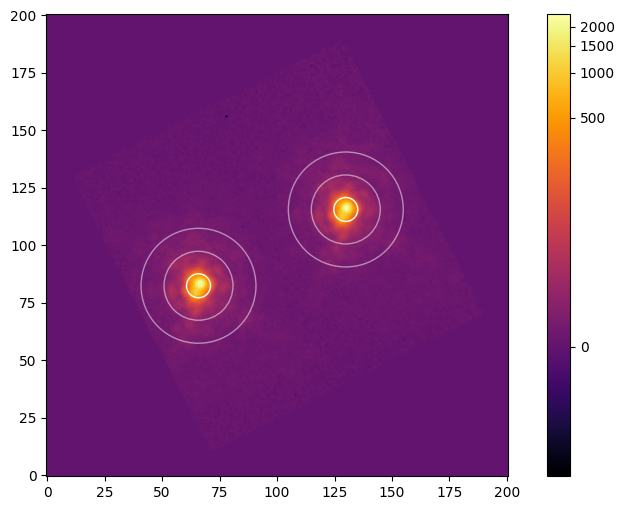

In [112]:
centroid_guesses = ([65,83],[133,118])
annuli_radii = ([15,25],[15,25])
#charis_centroids_one_psf(image_data,centroid_guesses[0],centroid_guesses[1],45,10)
write_fits_info_to_csv_psf('/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/cubes_forcsv','/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/raw','/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/csvs/bin10.csv',centroid_guesses,(15,15),45,10,bkgd_annuli_radii=([15,25],[15,25]),plot=True,hwp_order=[0,45,22.5,67.5])

In [116]:
interleaved_values, interleaved_stds,config_list  = inst.read_csv('/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/csvs/bin10.csv')
processed_data = inst.process_dataset(interleaved_values)
print(processed_data)


[ 0.0026106  -0.03396872 -0.00889762 -0.03370388  0.00075782 -0.03383459
 -0.01049209 -0.02983925]
